# Step 1: 安装必要的库

In [ ]:
!pip install -q scikit-learn seaborn spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Step 2: 导入必要的库

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups  # 加载数据集
from sklearn.feature_extraction.text import TfidfVectorizer  # 提取 TF-IDF 特征
from sklearn.decomposition import TruncatedSVD  # 奇异值分解（SVD）
from sklearn.cluster import KMeans, SpectralClustering  # 聚类算法
from sklearn.metrics import adjusted_rand_score, silhouette_score  # 评估指标
from sklearn.preprocessing import normalize  # 特征归一化
from tqdm import tqdm  # 进度条显示
import matplotlib.pyplot as plt  # 绘图工具
import seaborn as sns  # 数据可视化库
from sklearn.manifold import TSNE  # t-SNE 降维
import spacy  # 自然语言处理库

# 加载 spaCy 的英语模型，禁用解析器和命名实体识别以提高效率
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Step 3: 加载 20 Newsgroups 数据集

In [ ]:
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))  # 移除标题、页脚和引用文本
X_text = data.data  # 文档内容
y_true = data.target  # 真实标签

# Step 4: 使用 spaCy 进行增强预处理

In [ ]:
def preprocess(text):
    if not isinstance(text, str) or not text.strip():
        return ''  # 如果不是字符串或为空，返回空字符串
    doc = nlp(text.lower())  # 将文本转换为小写并进行分词
    words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # 只保留字母字符且非停用词，并进行词形还原
    return ' '.join(words)  # 将处理后的单词重新组合成字符串

X_text_preprocessed = [preprocess(text) for text in X_text]  # 对所有文档进行预处理

# Step 5: 构建 TF-IDF 模型并应用增强预处理后的文本

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # 设置最大特征数为 5000 并移除英文停用词
X_tfidf = vectorizer.fit_transform(X_text_preprocessed)  # 提取 TF-IDF 特征

# Step 6: 应用 SVD 进行降维（LSA）

In [ ]:
svd = TruncatedSVD(n_components=200, random_state=42)  # 设置降维后的维度数为 200
X_lsa = svd.fit_transform(X_tfidf)  # 执行 SVD 降维

# 归一化特征向量到单位长度
X_tfidf_normalized = normalize(X_tfidf)
X_lsa_normalized = normalize(X_lsa)

# Step 7: 在两种表示上执行聚类

In [ ]:
kmeans_baseline = KMeans(n_clusters=len(np.unique(y_true)), random_state=42)  # 初始化 K-means 模型，簇数等于真实类别数
kmeans_lsa = KMeans(n_clusters=len(np.unique(y_true)), random_state=42)

kmeans_baseline.fit(X_tfidf_normalized)  # 对基线模型进行聚类
kmeans_lsa.fit(X_lsa_normalized)  # 对 LSA 模型进行聚类

y_pred_baseline = kmeans_baseline.labels_  # 获取基线模型的聚类结果
y_pred_lsa = kmeans_lsa.labels_  # 获取 LSA 模型的聚类结果

# Step 8: 评估聚类性能

In [ ]:
ari_baseline = adjusted_rand_score(y_true, y_pred_baseline)  # 计算调整兰德指数（ARI）
silhouette_baseline = silhouette_score(X_tfidf_normalized, y_pred_baseline)  # 计算轮廓系数

ari_lsa = adjusted_rand_score(y_true, y_pred_lsa)
silhouette_lsa = silhouette_score(X_lsa_normalized, y_pred_lsa)

# 打印结果
print(f"基线模型 (TF-IDF) ARI: {ari_baseline:.4f}, Silhouette Score: {silhouette_baseline:.4f}")
print(f"LSA 模型 (TF-IDF + SVD) ARI: {ari_lsa:.4f}, Silhouette Score: {silhouette_lsa:.4f}")

基线模型 (TF-IDF) ARI: 0.0285, Silhouette Score: -0.0091
LSA 模型 (TF-IDF + SVD) ARI: 0.1264, Silhouette Score: 0.0387


# Step 9: 比较结果

In [ ]:
comparison_results = {
    "Model": ["基线模型 (TF-IDF)", "LSA 模型 (TF-IDF + SVD)"],
    "ARI": [ari_baseline, ari_lsa],
    "Silhouette Score": [silhouette_baseline, silhouette_lsa]
}

comparison_df = pd.DataFrame(comparison_results)
print("\n比较结果:")
print(comparison_df)


比较结果:
                   Model       ARI  Silhouette Score
0          基线模型 (TF-IDF)  0.028452         -0.009078
1  LSA 模型 (TF-IDF + SVD)  0.126449          0.038716


# Step 10: 使用 t-SNE 可视化

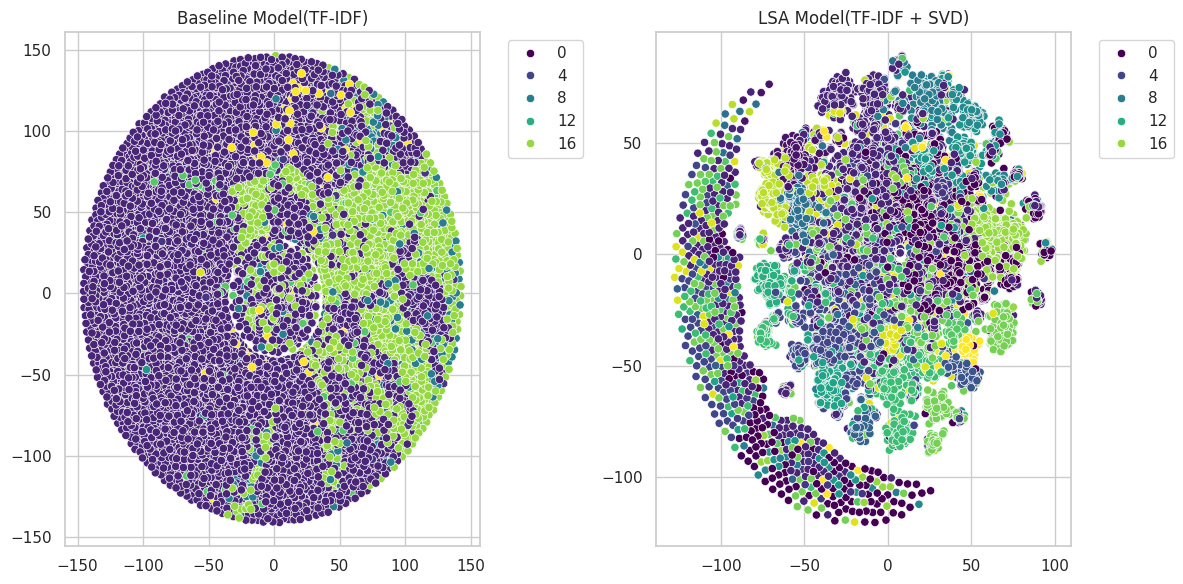

In [ ]:
tsne = TSNE(n_components=2, random_state=42)  # 使用 t-SNE 将高维数据降维到 2D
X_tfidf_tsne = tsne.fit_transform(X_tfidf_normalized.toarray())
X_lsa_tsne = tsne.fit_transform(X_lsa_normalized)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tfidf_tsne[:, 0], y=X_tfidf_tsne[:, 1], hue=y_pred_baseline, palette='viridis')
plt.title('Baseline Model(TF-IDF)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_lsa_tsne[:, 0], y=X_lsa_tsne[:, 1], hue=y_pred_lsa, palette='viridis')
plt.title('LSA Model(TF-IDF + SVD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()